# Classifiying Fashion MNIST with Pytorch

In [513]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms,Compose
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

In [514]:
IMG_WIDTH = 28
IMG_HEIGHT = 28

transformations = Compose([transforms.Resize((IMG_WIDTH,IMG_HEIGHT)),transforms.ToTensor()])

train_data = dsets.FashionMNIST(root='./fmnist',download=True,train=True,transform=transformations)
val_data = dsets.FashionMNIST(root="./fmnist",download=True,train=False,transform=transformations)


In [515]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMG_WIDTH, IMG_WIDTH), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

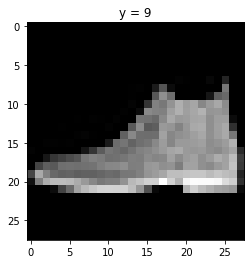

In [516]:
show_data(val_data[0])

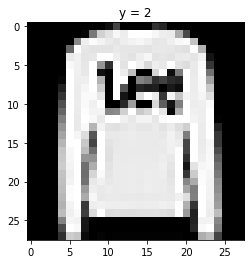

In [517]:
show_data(val_data[1])

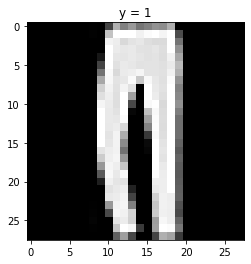

In [518]:
show_data(val_data[2])

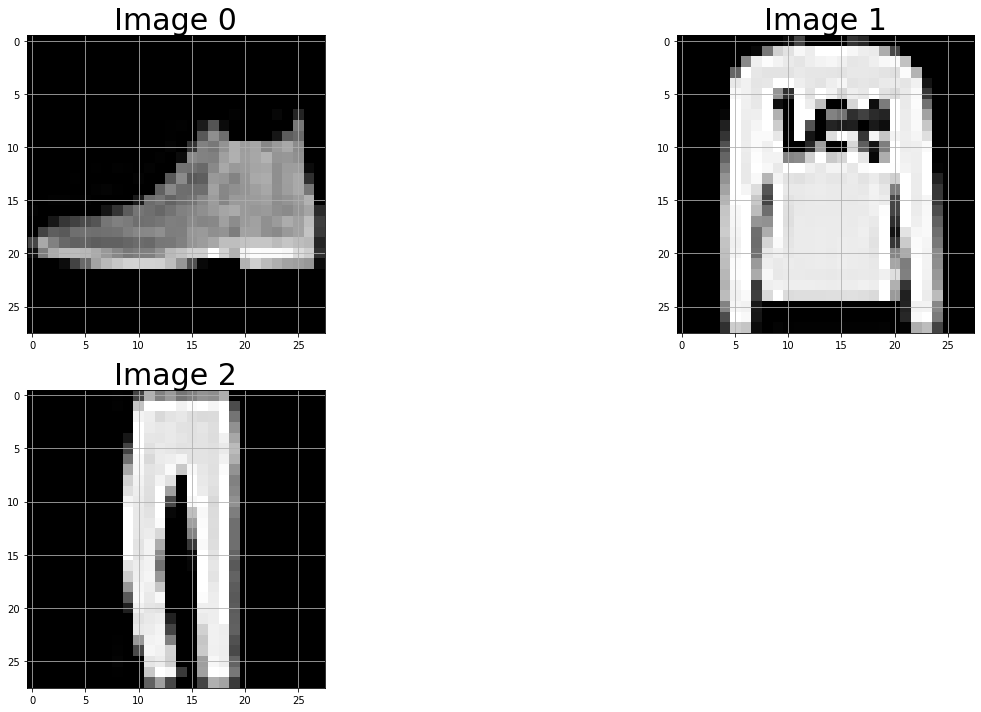

In [519]:
show_image_list([val_data[0][0].numpy().reshape(IMG_WIDTH, IMG_WIDTH),val_data[1][0].numpy().reshape(IMG_WIDTH, IMG_WIDTH),val_data[2][0].numpy().reshape(IMG_WIDTH, IMG_WIDTH)])

## Creating the model

Model is a simple CNN.

Architecture :
- Convolutionnal layer with (5,5) kernel, padding=2 and stride=1
- ReLU
- Maxpool with (2,2) kernel
-  Convolutionnal layer with (5,5) kernel, padding=2 and stride =1
- ReLU
- Maxpool with (2,2) kernel
- fully connected with 32 neurons
- fully connected layer with 32 neurons
- output layer with 10 neurons



In [520]:
class CNN(nn.Module):
    """Simple CNN architecture"""
    def __init__(self,out1=16,out2=32):
        super(CNN,self).__init__()

        # First convolutionnal layer
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=out1,kernel_size=5,padding=2)
        self.relu1 = nn.ReLU()  

        # First pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        # Second convolutionnal layer
        self.conv2 = nn.Conv2d(in_channels=out1,out_channels=out2,kernel_size=5,stride=1,padding=2)
        self.relu2 = nn.ReLU()

        # second pooling layer
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # Fully connected 1
        self.fc1 = nn.Linear(out2*7*7,32)
        self.relu3 = nn.ReLU()

        # Fully connected 2
        self.fc2 = nn.Linear(32,32)
        self.relu4 = nn.ReLU()

        # Output layer
        self.out = nn.Linear(32,10)

    def forward(self,x):
        # Conv1 + activation
        x = self.conv1(x)
        x = self.relu1(x)

        # Pooling 1
        x = self.pool1(x)

        # Conv2 + activation
        x = self.conv2(x)
        x = self.relu2(x)

        # Pooling 2
        x = self.pool2(x)

        # Flattening 
        # print(x.size())
        x = x.view(-1,x.size(1)*7*7)

        # Fully connected 1
        x = self.fc1(x)
        x = self.relu3(x)

        # Fully connected 2
        x = self.fc2(x)
        x = self.relu4(x)

        # Output layer
        x = self.out(x)

        return x
        
        

## Training the model

In [521]:
def train(model,optimizer,criterion,trainloader,valloader,epochs=4):

    N_test=len(valloader)
    accuracy_list=[]
    loss_list=[]
    cost=0
    for epoch in range(epochs):
        print(f"epoch {epoch} ")
        cost=0
        for x,y in trainloader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat,y)
            loss.backward()
            optimizer.step()
            cost +=loss.data

        loss_list.append(cost)    
        correct=0
        
        ## Evaluate the model
        #perform a prediction on the validation  data  
        for x_test, y_test in valloader:
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
    
    return accuracy_list,loss_list
    

In [522]:
model = CNN()
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

train_loader = DataLoader(dataset=train_data,batch_size=100)
val_loader = DataLoader(dataset=val_data,batch_size=100)

accuracy, loss = train(model,optimizer,criterion,train_loader,val_loader,epochs=3)

epoch 0 
epoch 1 
epoch 2 


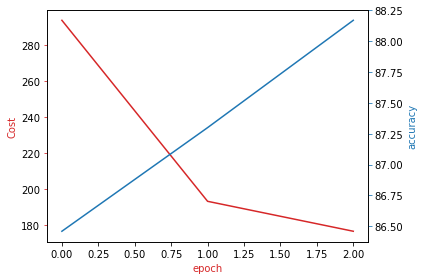

In [523]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(loss, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [524]:
torch.save(model,"CNN.pt")